In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

data = pd.read_csv(r'C:\Users\Wiktoria\Documents\PM\BTC-USD(1).csv')


data['Volume'] = data['Volume'].astype(str).str.replace(',', '').replace('-', '0').astype(float)

for col in ['Open', 'High', 'Low', 'Close']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[features]

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data = scaled_data[1000:]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

X = X.reshape((X.shape[0], X.shape[1], len(features)))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [39]:
#jak wielka sekwencja
print("X shape:", X.shape)  # (liczba próbek, długość sekwencji, liczba cech)
print("y shape:", y.shape)  # (liczba próbek,)

X shape: (1687, 60, 5)
y shape: (1687,)


In [40]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, Input, Multiply, Permute, RepeatVector, Activation
from tensorflow.keras.models import Model

# Funkcja warstwy uwagi
def attention_layer(inputs):
    a = Dense(1, activation="tanh")(inputs)
    a = Dense(1, activation="tanh")(a)
    a = tf.keras.layers.Flatten()(a)
    a = Activation('softmax')(a)
    a = RepeatVector(inputs.shape[-1])(a)
    a = Permute([2, 1])(a)
    output_attention = Multiply()([inputs, a])
    return output_attention

# Funkcja tworząca model
def create_model(input_shape, 
                 units=50, 
                 use_attention_before_dropout=True,
                 rnn_type='GRU', 
                 dropout_rate=0.2):
    
    # Warstwa wejściowa
    inputs = Input(shape=input_shape)

    # Warstwa RNN (GRU lub LSTM)
    if rnn_type == 'GRU':
        rnn_out = GRU(units, return_sequences=True)(inputs)
    elif rnn_type == 'LSTM':
        rnn_out = LSTM(units, return_sequences=True)(inputs)
    else:
        raise ValueError("rnn_type musi być 'GRU' lub 'LSTM'")

    # Warstwa uwagi, przed dropout, jeśli zaznaczono
    if use_attention_before_dropout:
        attention = attention_layer(rnn_out)
        # Dropout po pierwszej warstwie RNN
        dropout1 = Dropout(dropout_rate)(attention)
        attention = dropout1

    else:
        # Dropout po pierwszej warstwie RNN
        dropout1 = Dropout(dropout_rate)(rnn_out)
        attention = attention_layer(dropout1)

    # Druga warstwa RNN
    if rnn_type == 'GRU':
        rnn_out2 = GRU(units, return_sequences=False)(attention)
    elif rnn_type == 'LSTM':
        rnn_out2 = LSTM(units, return_sequences=False)(attention)
    
    dropout2 = Dropout(dropout_rate)(rnn_out2)


    # Wyjście (jedna jednostka, bez aktywacji do przewidywania wartości ciągłej)
    outputs = Dense(1)(dropout2)

    # Tworzenie modelu
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    return model


In [41]:
# Funkcja do prognozowania w interwałach
def predict_in_intervals(model, X_test, interval_size=1000):
    predictions = []
    for start in range(0, len(X_test), interval_size):
        end = min(start + interval_size, len(X_test))
        predictions_interval = model.predict(X_test[start:end])
        predictions.append(predictions_interval)
    return np.concatenate(predictions)

In [42]:

input_shape = (X_train.shape[1], len(features))  # dopasowujemy do danych
#Model LSTM z wartwa uwagi przed dropout, units 50, dropout 0.3
model_lstm_1before = create_model(input_shape=input_shape, 
                                   units=50, use_attention_before_dropout= True,
                                   rnn_type='LSTM', 
                                   dropout_rate=0.3)

#Model LSTM z wartwa uwagi po dropout, units 50, dropout 0.3
model_lstm_1after = create_model(input_shape=input_shape, 
                                       units=50, 
                                       use_attention_before_dropout=False, 
                                       rnn_type='LSTM', 
                                       dropout_rate=0.3)

#Model LSTM z wartwa uwagi przed dropout, units 100, dropout 0.3
input_shape = (X_train.shape[1], len(features))  # dopasowujemy do danych
model_lstm_2before = create_model(input_shape=input_shape, 
                                   units=100, use_attention_before_dropout= True,
                                   rnn_type='LSTM', 
                                   dropout_rate=0.3)

#Model LSTM z wartwa uwagi po dropout, units 100, dropout 0.3
model_lstm_2after = create_model(input_shape=input_shape, 
                                       units=100, 
                                       use_attention_before_dropout=False, 
                                       rnn_type='LSTM', 
                                       dropout_rate=0.3)

#Model LSTM z wartwa uwagi przed dropout, units 100, dropout 0.6
input_shape = (X_train.shape[1], len(features))  # dopasowujemy do danych
model_lstm_3before = create_model(input_shape=input_shape, 
                                   units=100, use_attention_before_dropout= True,
                                   rnn_type='LSTM', 
                                   dropout_rate=0.6)

#Model LSTM z wartwa uwagi po dropout, units 100, dropout 0.6
model_lstm_3after = create_model(input_shape=input_shape, 
                                       units=100, 
                                       use_attention_before_dropout=False, 
                                       rnn_type='LSTM', 
                                       dropout_rate=0.6)



In [43]:
history1 = model_lstm_1after.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 57.2372 - val_loss: 74.3314
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 27.5903 - val_loss: 65.0315
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 20.8447 - val_loss: 23.1939
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 16.1200 - val_loss: 18.9024
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 14.6375 - val_loss: 26.6281
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 13.1123 - val_loss: 21.1875
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 12.4343 - val_loss: 17.2281
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 11.8421 - val_loss: 21.0185
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 10.8699 - val_loss: 15.6396
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 11.2703 - val_loss: 25.7176
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 12.0784 - val_loss: 16.0912
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s

In [44]:
history2 = model_lstm_1before.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 54.2066 - val_loss: 67.3363
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 26.5819 - val_loss: 56.0866
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 19.6165 - val_loss: 13.9569
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 15.7765 - val_loss: 13.1270
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 16.6043 - val_loss: 33.5245
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 12.9804 - val_loss: 18.4624
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 12.3201 - val_loss: 18.1344
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 12.5138 - val_loss: 19.3727
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 13.7980 - val_loss: 9.6564
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 11.3240 - val_loss: 9.8365
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 10.7378 - val_loss: 9.0200
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33

In [45]:
history3 = model_lstm_2after.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 49.1993 - val_loss: 68.1862
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 21.4818 - val_loss: 16.8745
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 17.1151 - val_loss: 21.4587
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 14.0974 - val_loss: 14.6110
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 14.5278 - val_loss: 11.5699
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 12.4730 - val_loss: 15.5491
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 12.3061 - val_loss: 12.1682
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 11.9470 - val_loss: 9.5343
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 10.8970 - val_loss: 10.1407
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 10.7020 - val_loss: 9.8243
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 10.0798 - val_loss: 9.7842
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 53

In [46]:
history4 = model_lstm_2before.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 48.5843 - val_loss: 59.8525
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 22.5696 - val_loss: 28.6462
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 14.9431 - val_loss: 20.2810
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 12.9260 - val_loss: 10.8045
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 12.5364 - val_loss: 16.6774
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 11.8186 - val_loss: 12.8303
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 11.1951 - val_loss: 10.0883
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 11.8108 - val_loss: 11.2557
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 9.9757 - val_loss: 8.9420
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 9.8872 - val_loss: 8.3483
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 9.5341 - val_loss: 11.4426
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms

In [47]:
history5 = model_lstm_3after.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 51.8734 - val_loss: 61.7292
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 25.0598 - val_loss: 33.8847
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 19.7629 - val_loss: 37.5402
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 17.7487 - val_loss: 16.9178
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 16.2447 - val_loss: 10.4489
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 14.9702 - val_loss: 21.1763
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 15.2164 - val_loss: 14.9915
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 13.4665 - val_loss: 15.1643
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 12.8319 - val_loss: 15.6844
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 12.1337 - val_loss: 12.3076
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 10.9757 - val_loss: 13.6032
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s

In [74]:
history6 = model_lstm_3before.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 52.0025 - val_loss: 62.4883
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 22.4136 - val_loss: 14.2329
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 18.5976 - val_loss: 28.6853
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 18.3166 - val_loss: 21.1235
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 16.5154 - val_loss: 13.8869
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 17.6494 - val_loss: 15.8795
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 13.4153 - val_loss: 12.0854
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 13.3954 - val_loss: 11.4362
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 12.0556 - val_loss: 10.9471
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 11.3388 - val_loss: 19.3953
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 12.1376 - val_loss: 20.8255
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s

In [49]:
import matplotlib.pyplot as plt

def plot_validation_loss(history, figsize=(14, 8), title='Model Validation Loss Over Epochs'):
    plt.figure(figsize=figsize)
    plt.plot(history.history['val_loss'], color='darkred', linestyle='-', linewidth=1.5, label='Validation Loss')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Validation Loss (Mean Absolute Percentage Error)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

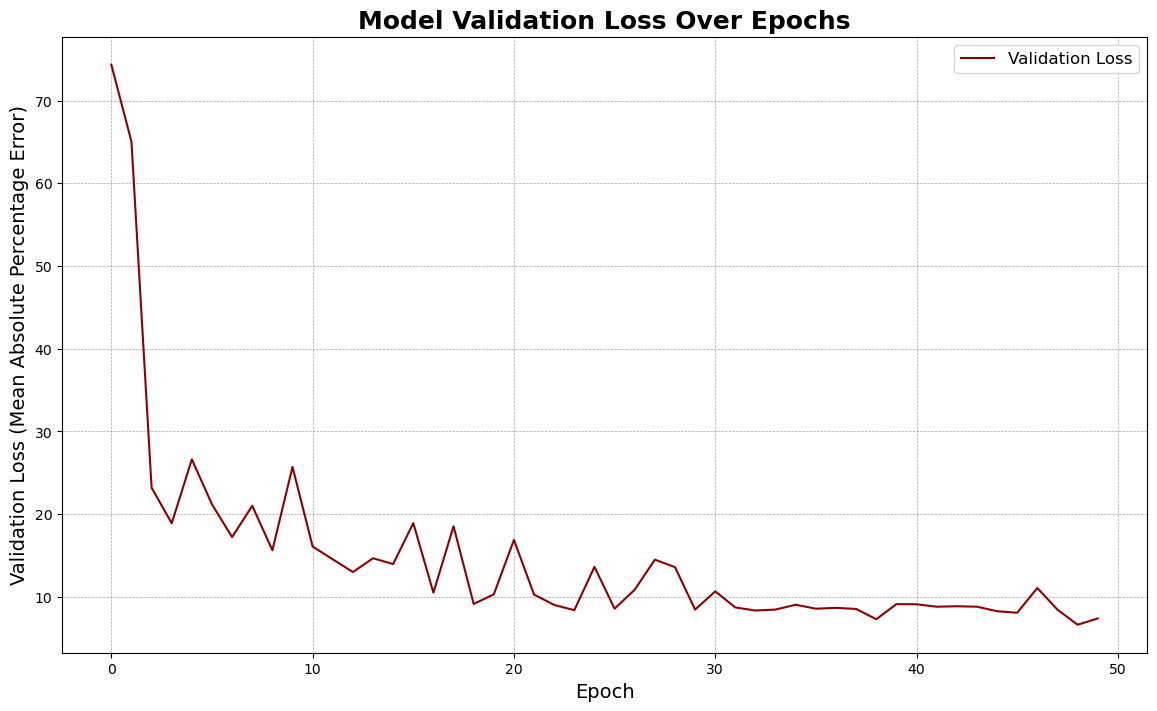

In [50]:
plot_validation_loss(history1)

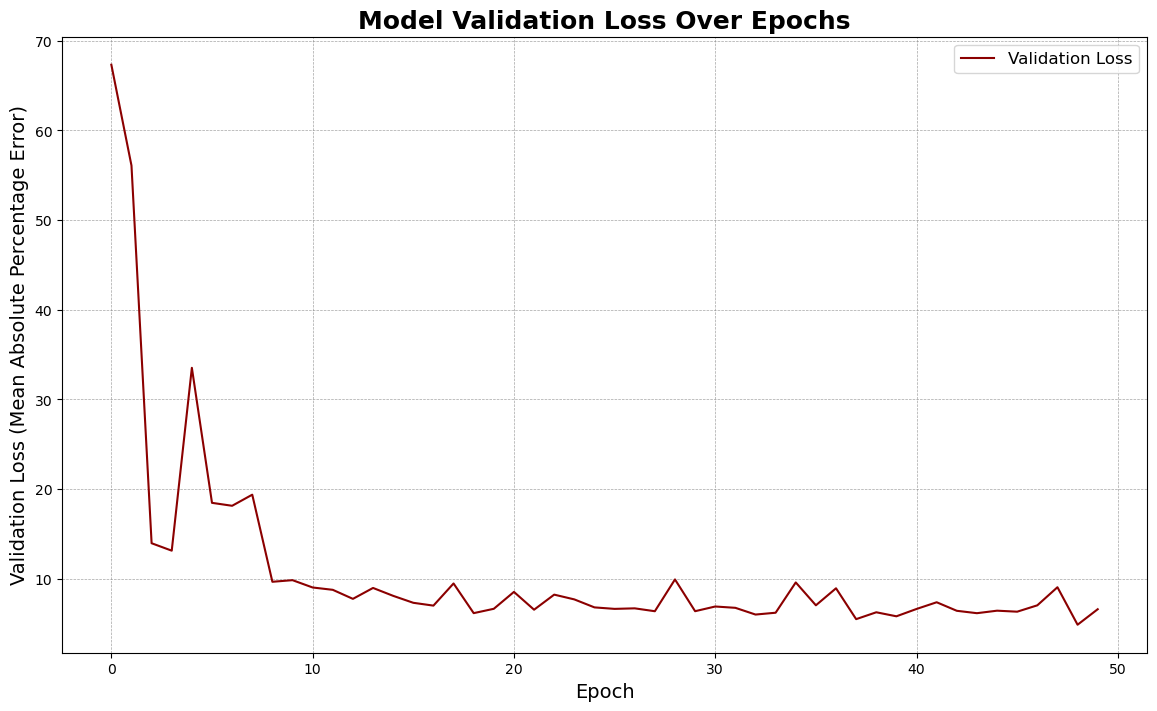

In [51]:
plot_validation_loss(history2)

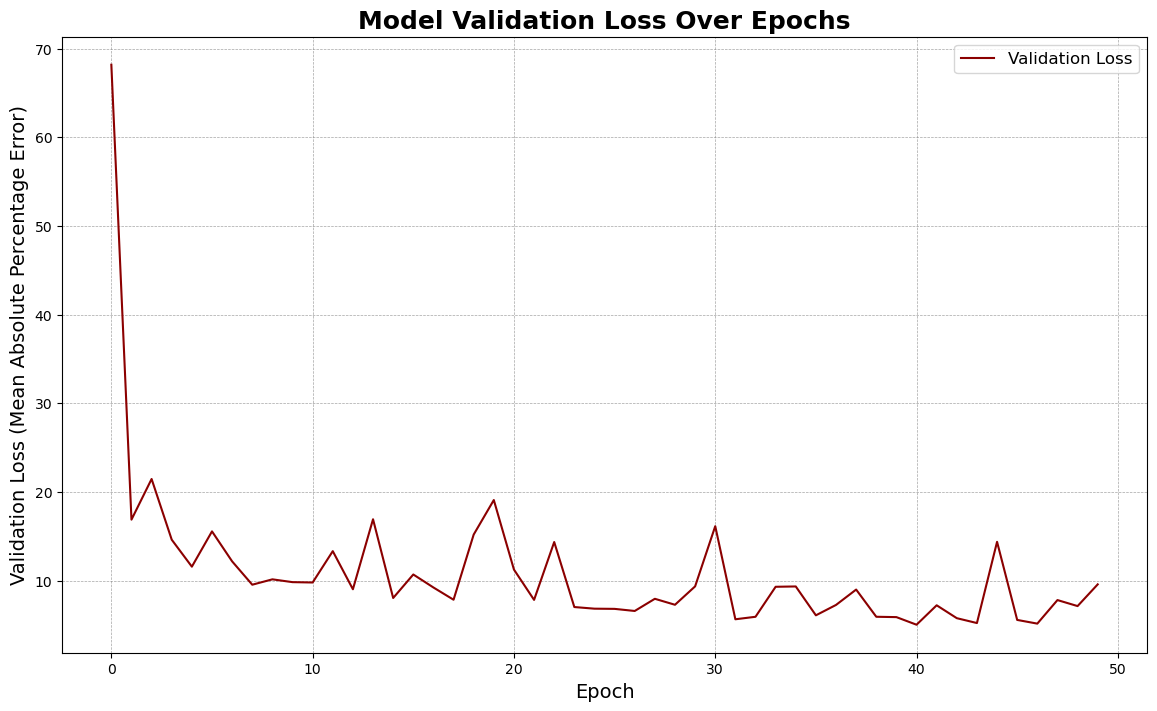

In [52]:
plot_validation_loss(history3)

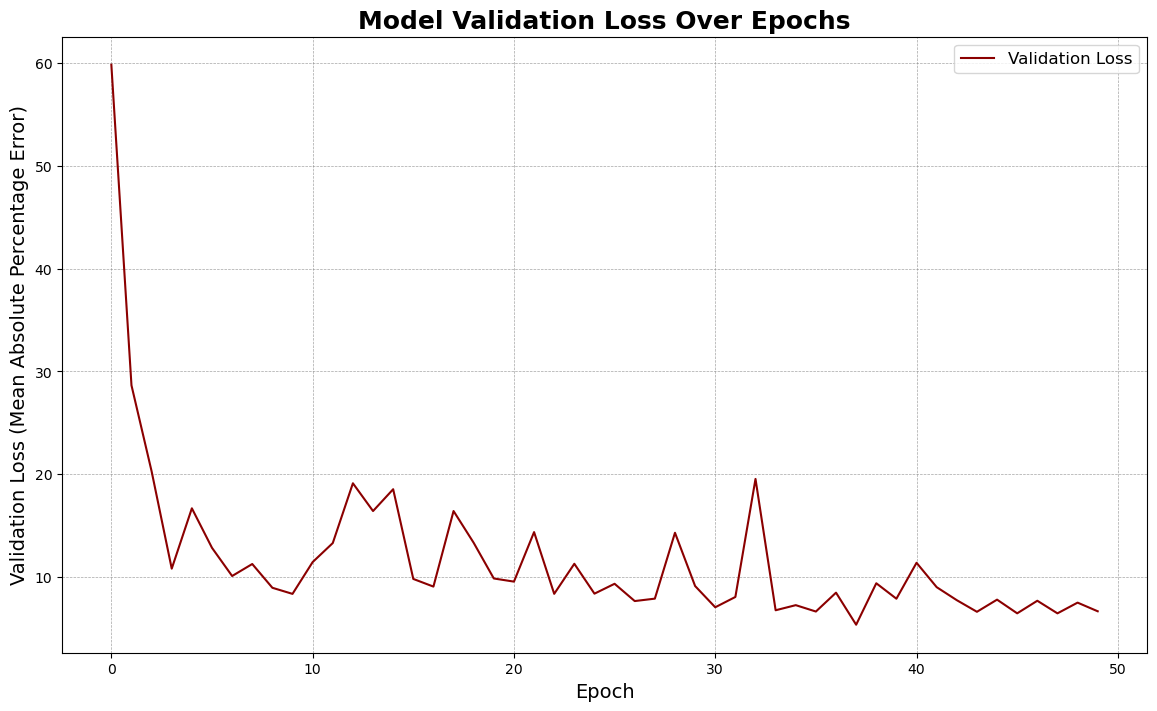

In [53]:
plot_validation_loss(history4)

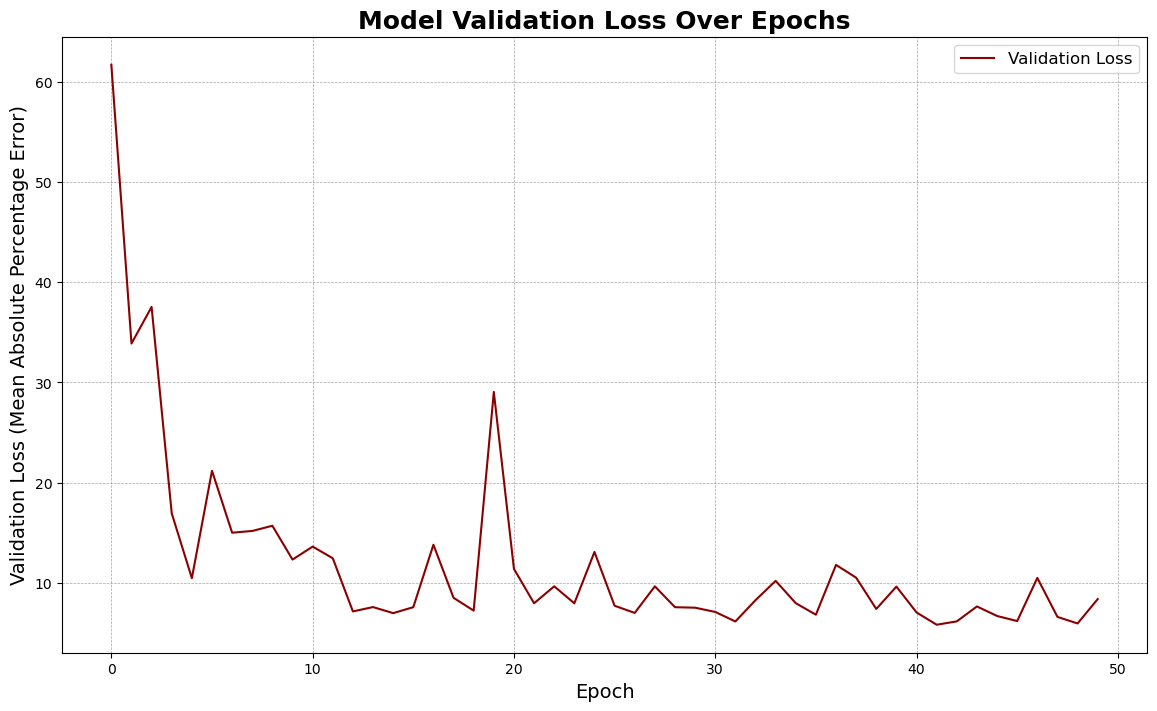

In [54]:
plot_validation_loss(history5)

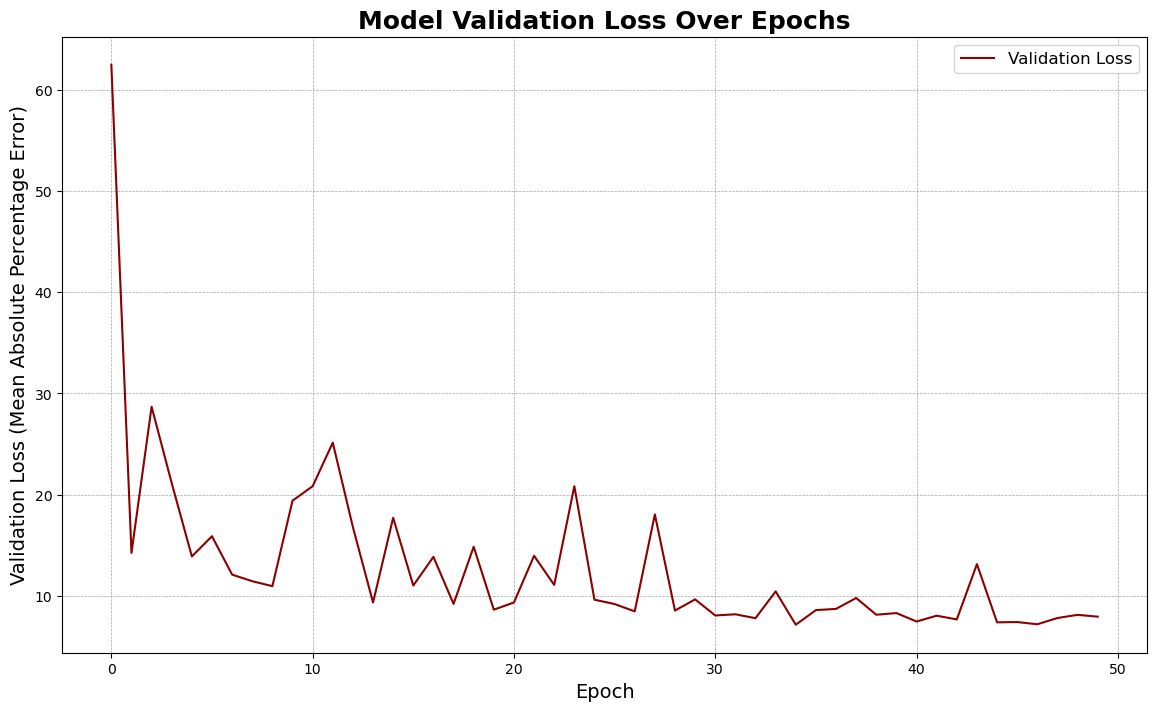

In [75]:
plot_validation_loss(history6)

In [56]:
import matplotlib.pyplot as plt

def plot_training_loss(history, figsize=(14, 8), title='Model Training Loss Over Epochs'):
    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], color='darkred', linestyle='-', linewidth=1.5, label='Training Loss')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Training Loss (Mean Absolute Percentage Error)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()


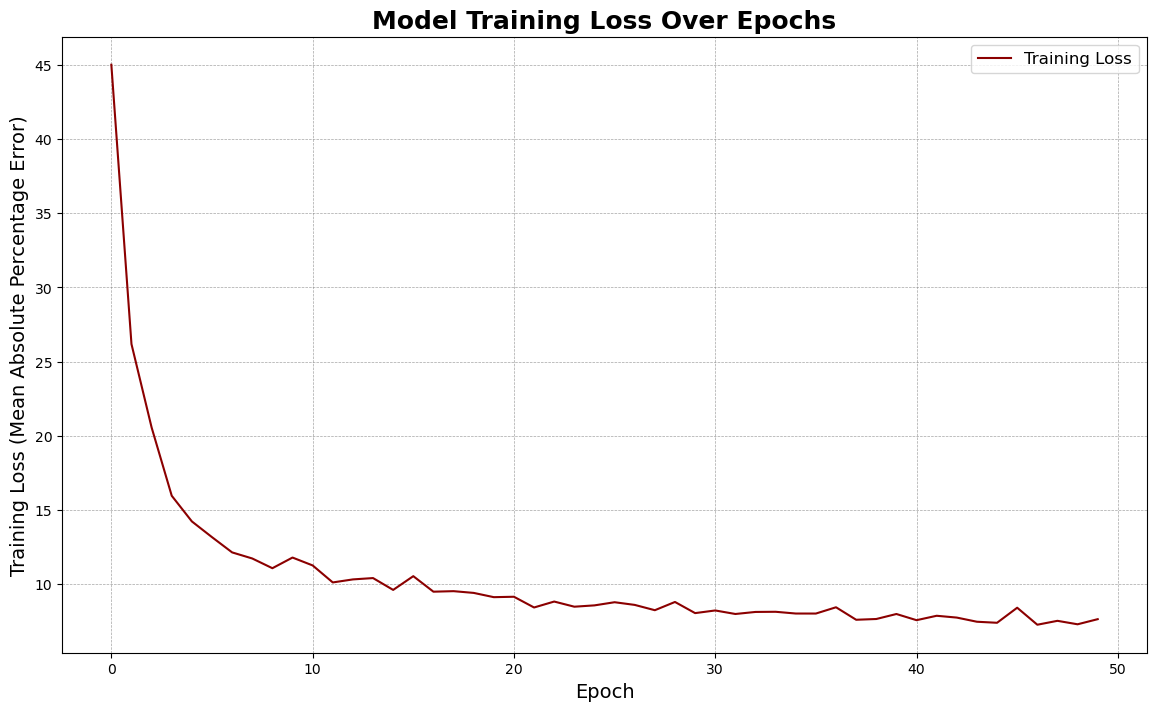

In [57]:
plot_training_loss(history1)


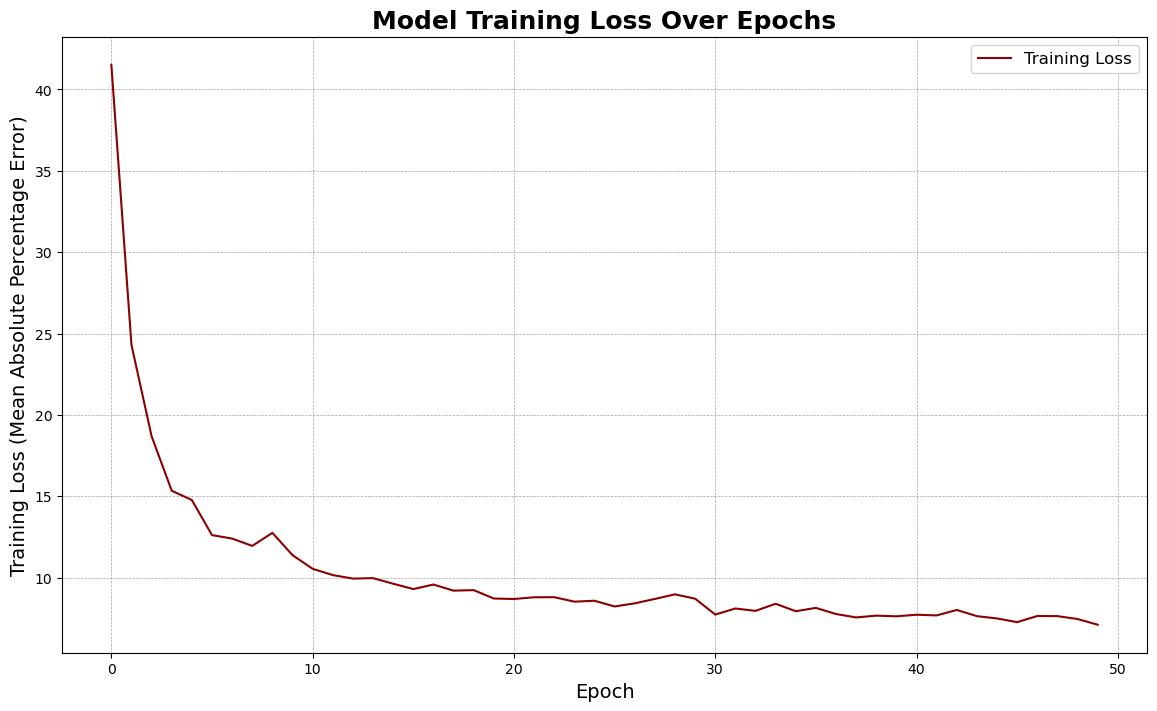

In [58]:
plot_training_loss(history2)


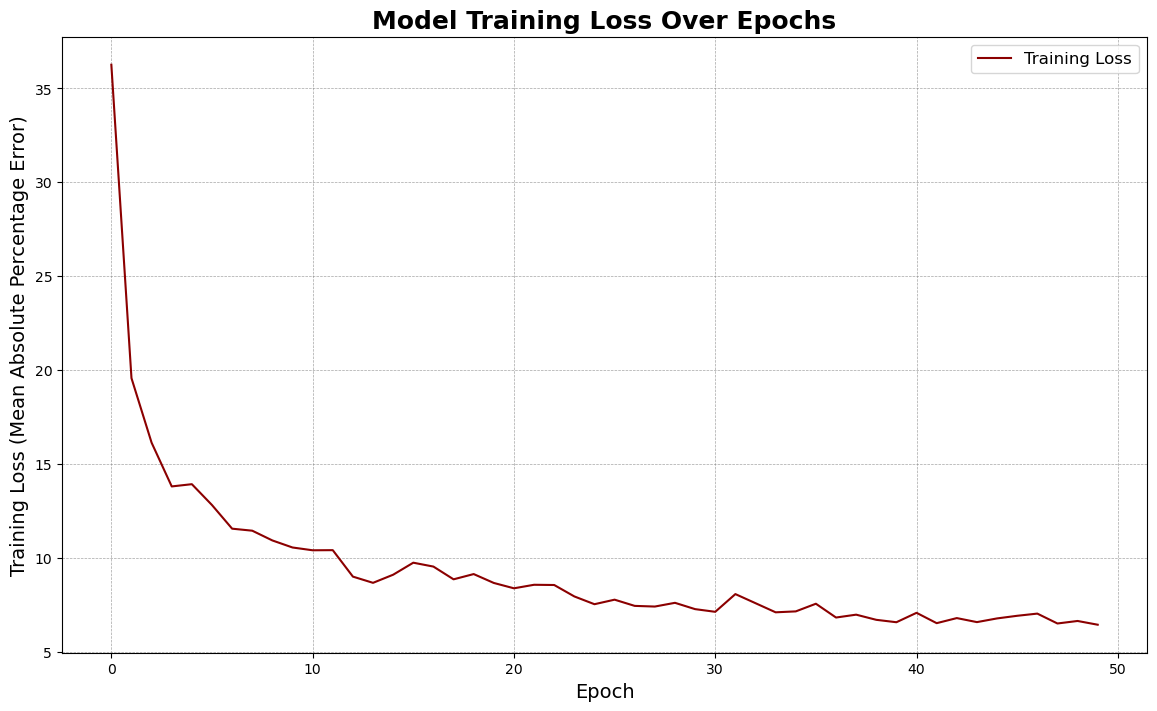

In [59]:
plot_training_loss(history3)


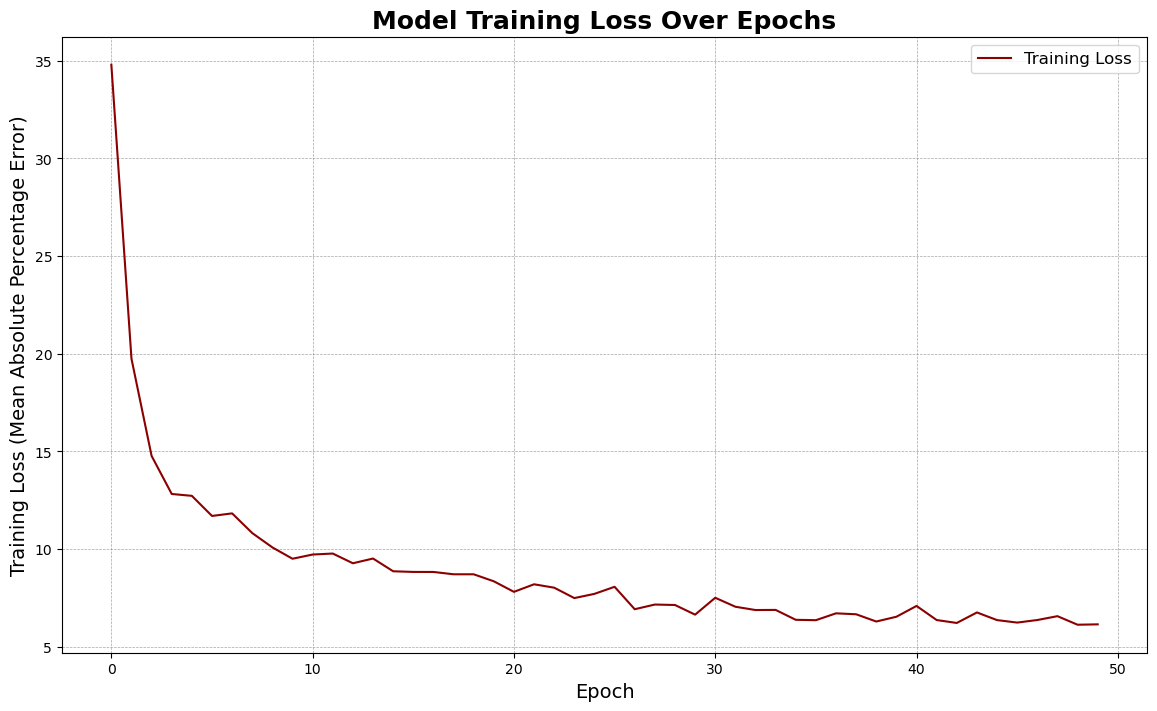

In [60]:
plot_training_loss(history4)


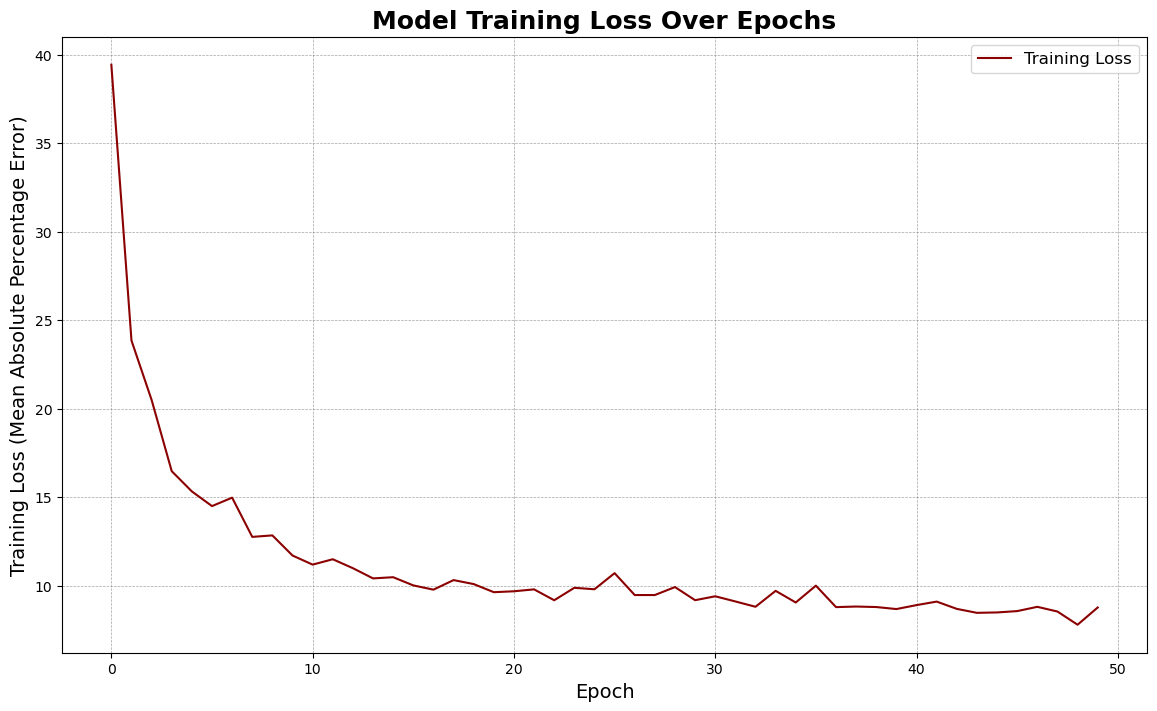

In [61]:
plot_training_loss(history5)

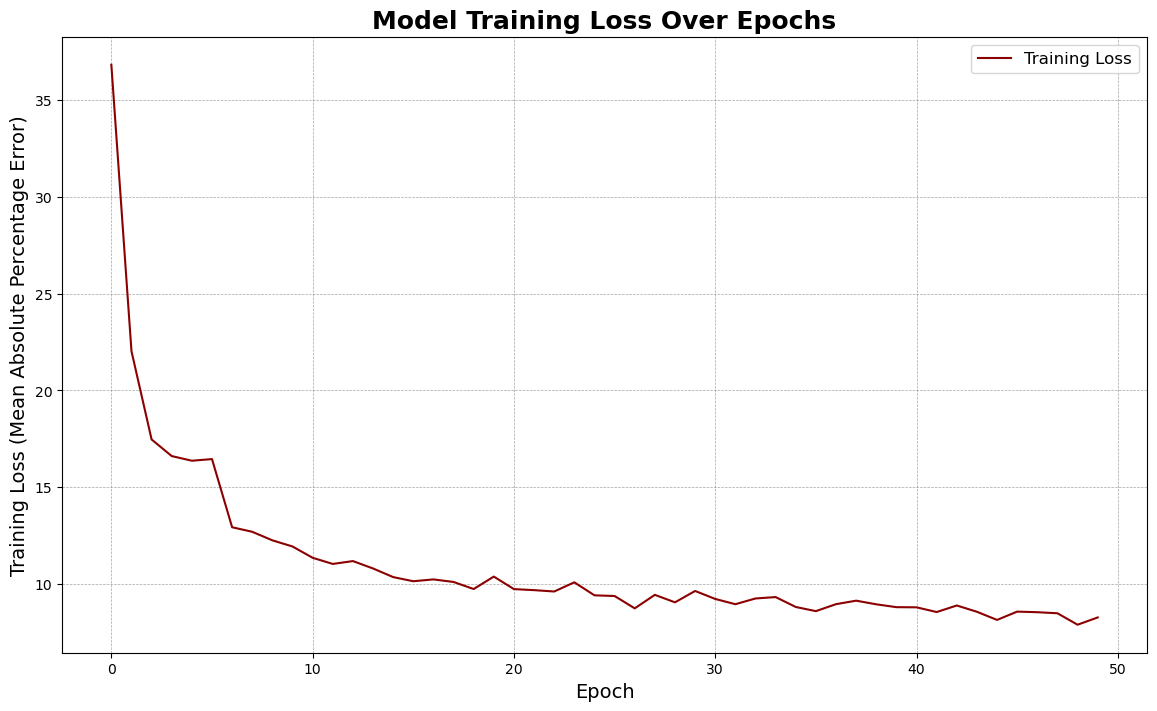

In [76]:
plot_training_loss(history6)

In [63]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_price_prediction_with_zoom(actual_prices, predicted_prices, start, end, title='Bitcoin Close Price Prediction vs Actual Prices'):
   
    # Obliczenie minimalnych i maksymalnych wartości dla zaznaczonego zakresu
    min_price = min(min(actual_prices[start:end]), min(predicted_prices[start:end]))
    max_price = max(max(actual_prices[start:end]), max(predicted_prices[start:end]))

    # Tworzenie głównego wykresu
    fig, ax = plt.subplots(figsize=(14, 8))

    # Główny wykres rzeczywistych i przewidywanych cen
    ax.plot(actual_prices, color='blue', linestyle='-', linewidth=1.5, label='Actual Close Price')
    ax.plot(predicted_prices, color='red', linestyle='--', linewidth=1.5, label='Predicted Close Price')

    # Dodanie prostokąta zaznaczającego zakres
    rect = patches.Rectangle((start, min_price), 
                             end - start, 
                             max_price - min_price, 
                             linewidth=1.5, edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(rect)

    # Tytuł i etykiety osi
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (Days)', fontsize=14)
    ax.set_ylabel('Price (USD)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Tworzenie mniejszego wykresu (powiększony wycinek) w prawym górnym rogu
    ax_inset = fig.add_axes([0.6, 0.55, 0.3, 0.3])
    ax_inset.plot(range(start, end), actual_prices[start:end], color='blue', linestyle='-', linewidth=1.5)
    ax_inset.plot(range(start, end), predicted_prices[start:end], color='red', linestyle='--', linewidth=1.5)
    ax_inset.set_title('Zoomed-in', fontsize=10)
    ax_inset.set_xlabel('Time', fontsize=8)
    ax_inset.set_ylabel('Price', fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)
    ax_inset.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.show()


In [64]:
# Funkcja do prognozowania w interwałach
def predict_in_intervals(model, X_test, interval_size=1000):
    predictions = []
    for start in range(0, len(X_test), interval_size):
        end = min(start + interval_size, len(X_test))
        predictions_interval = model.predict(X_test[start:end])
        predictions.append(predictions_interval)
    return np.concatenate(predictions)

In [65]:
def predict_and_plot_with_zoom(model, X_test, y_test, scaler, start=50, end=80):
    # Prognozowanie na interwałach
    predicted_prices_intervals = predict_in_intervals(model, X_test, interval_size=1000)
 # Prognoza i skalowanie na oryginalną skalę
    predicted_prices = model.predict(X_test)
    
    # Przywrócenie skali i przygotowanie do wykresu
    predicted_prices_intervals = np.concatenate([predicted_prices_intervals] * 5, axis=1)
    predicted_prices_intervals = scaler.inverse_transform(predicted_prices_intervals)
    actual_prices = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1)] * 5, axis=1))[:, 3]
    predicted_close_prices = predicted_prices_intervals[:, 3]

   
    
    # Rysowanie wykresu z powiększonym wycinkiem
    plot_price_prediction_with_zoom(actual_prices, predicted_close_prices, start, end)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


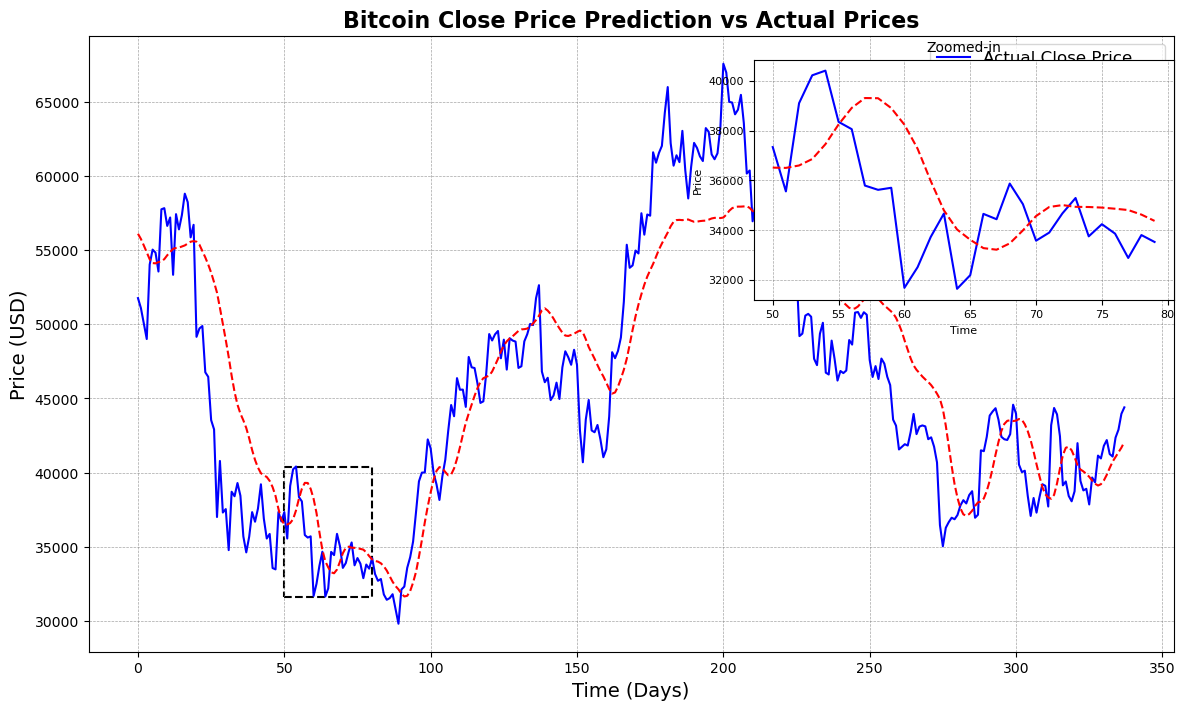

In [66]:
predict_and_plot_with_zoom(model_lstm_1after, X_test, y_test, scaler, start=50, end=80)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


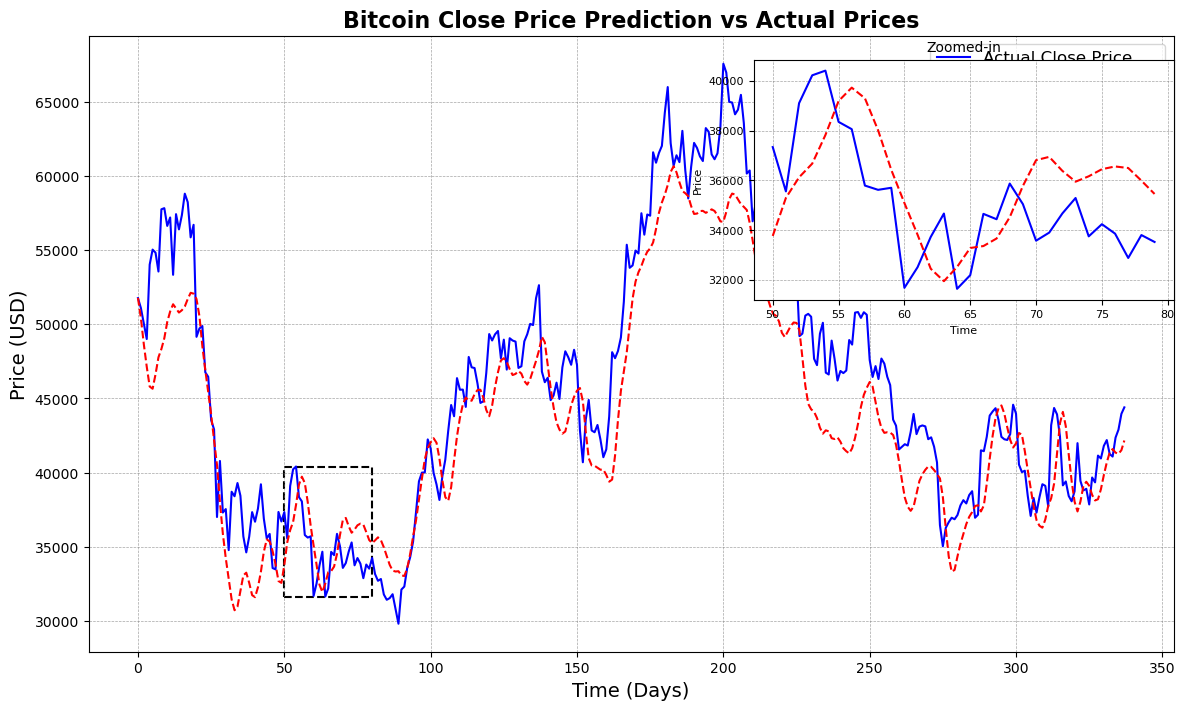

In [67]:
predict_and_plot_with_zoom(model_lstm_1before, X_test, y_test, scaler, start=50, end=80)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


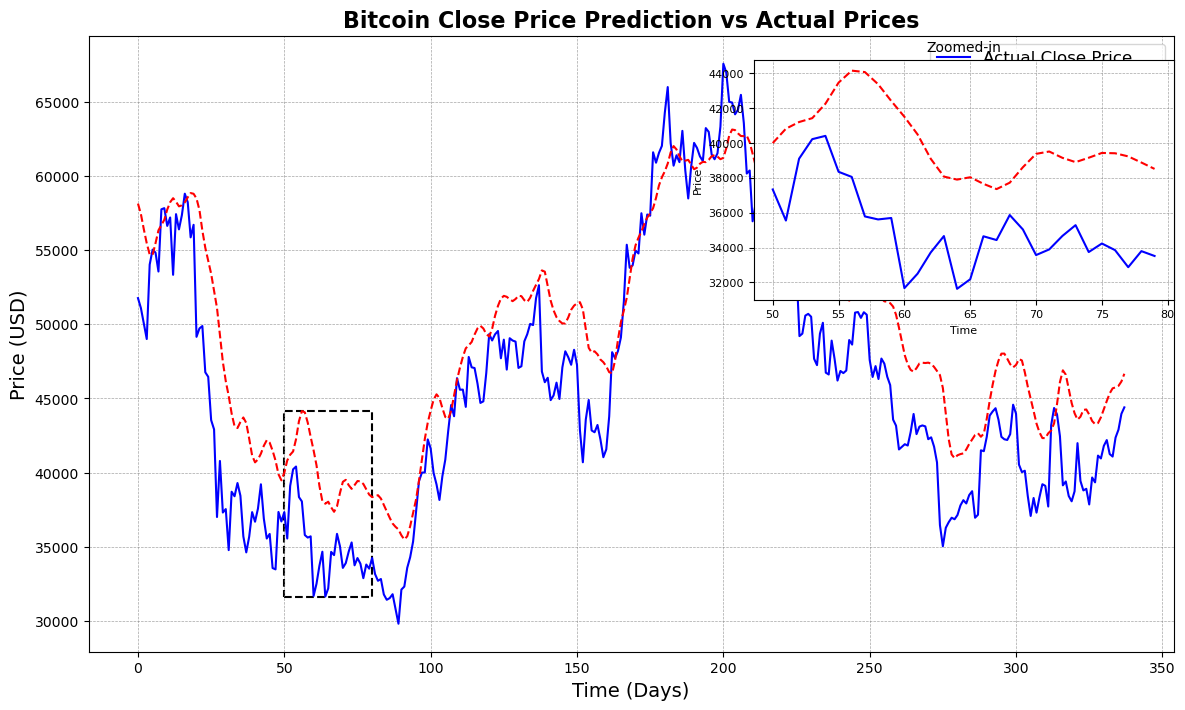

In [68]:
predict_and_plot_with_zoom(model_lstm_2after, X_test, y_test, scaler, start=50, end=80)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


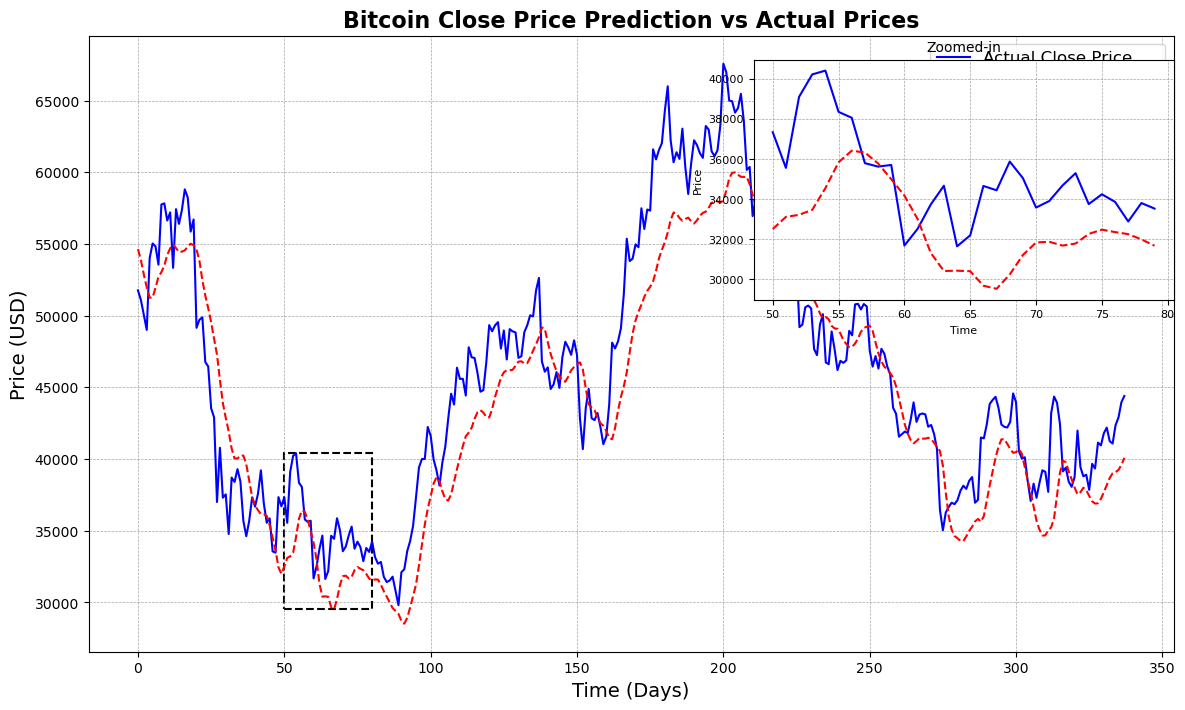

In [69]:
predict_and_plot_with_zoom(model_lstm_2before, X_test, y_test, scaler, start=50, end=80)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


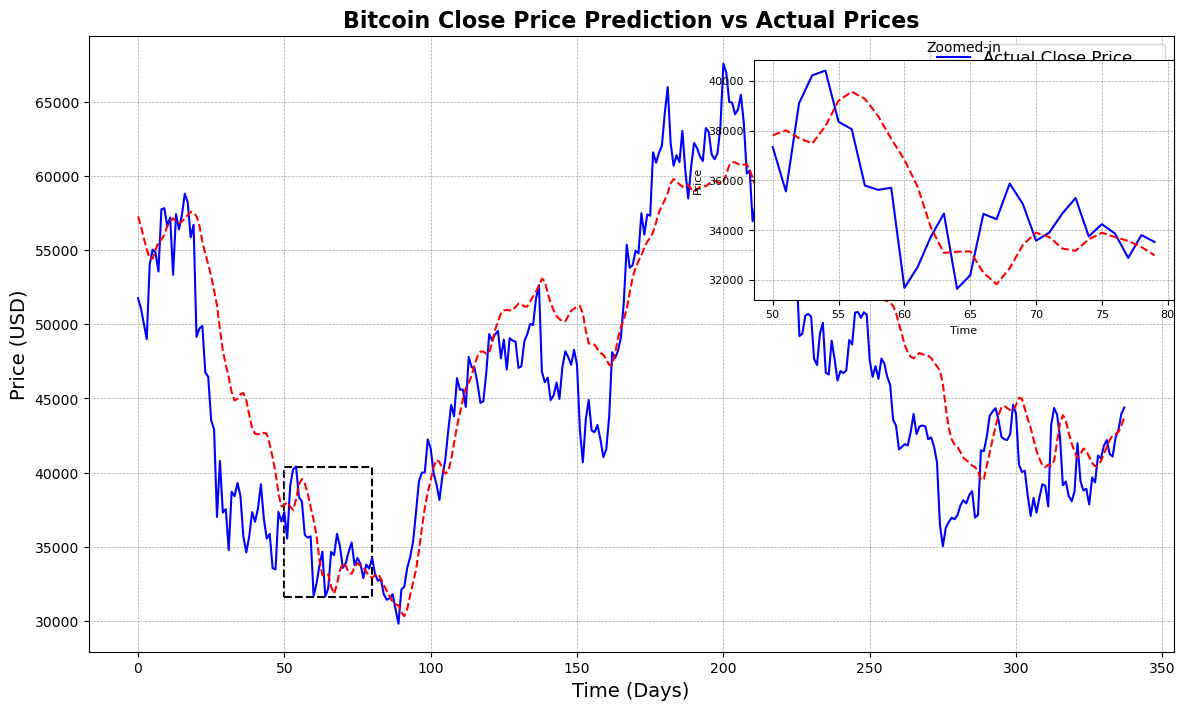

In [70]:
predict_and_plot_with_zoom(model_lstm_3after, X_test, y_test, scaler, start=50, end=80)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


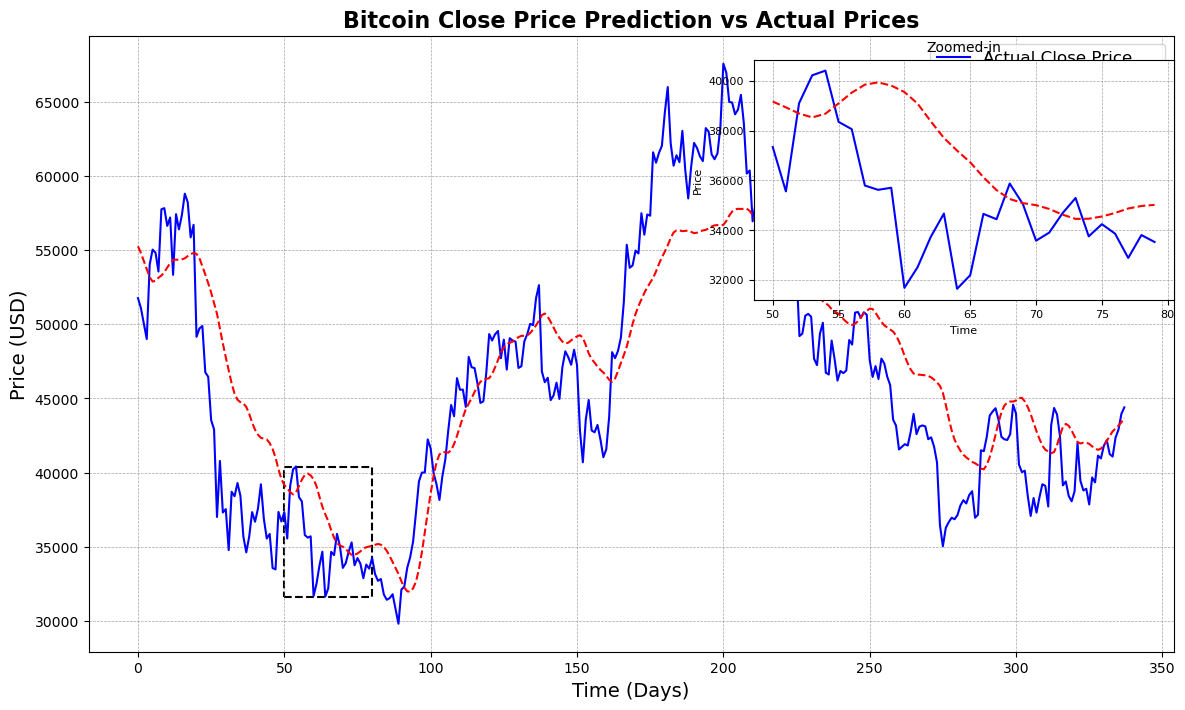

In [77]:
predict_and_plot_with_zoom(model_lstm_3before, X_test, y_test, scaler, start=50, end=80)

In [72]:
new_data = pd.read_csv(r'bitcoin_price_Training - Training.csv')
new_data['Volume'] = new_data['Volume'].astype(str).str.replace(',', '').replace('-', '0').astype(float)
for col in ['Open', 'High', 'Low', 'Close']:
    new_data[col] = pd.to_numeric(new_data[col], errors='coerce')
new_data.dropna(inplace=True)
# Step 2: Select the same features and scale
new_data = new_data[features]  # Using the same 'features' list as before
scaled_new_data = scaler.transform(new_data)  # Use the same scaler from training

X_new, y_new = create_sequences(scaled_new_data, SEQ_LENGTH)
X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], len(features)))

predict_and_plot_with_zoom(model_lstm_1after, X_new, y_new, scaler, start=50, end=80)


FileNotFoundError: [Errno 2] No such file or directory: 'bitcoin_price_Training - Training.csv'

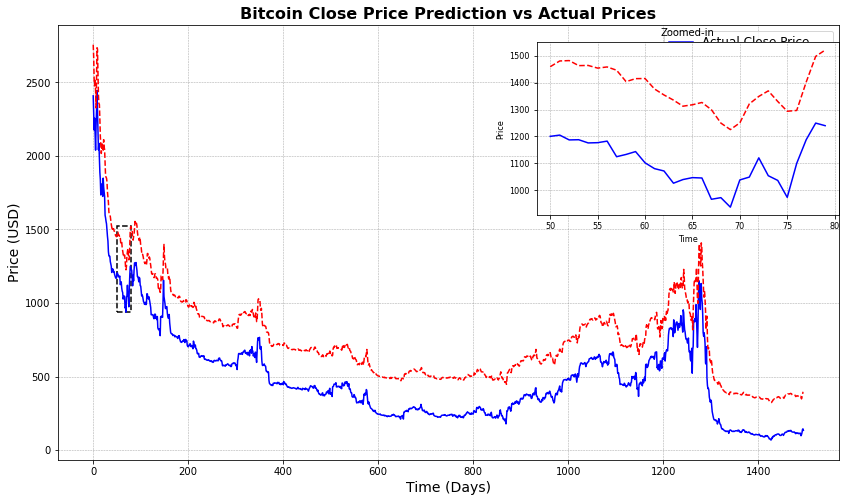

In [ ]:
new_data = pd.read_csv(r'bitcoin_price_Training - Training.csv')
new_data['Volume'] = new_data['Volume'].astype(str).str.replace(',', '').replace('-', '0').astype(float)
for col in ['Open', 'High', 'Low', 'Close']:
    new_data[col] = pd.to_numeric(new_data[col], errors='coerce')
new_data.dropna(inplace=True)
# Step 2: Select the same features and scale
new_data = new_data[features]  # Using the same 'features' list as before
scaled_new_data = scaler.transform(new_data)  # Use the same scaler from training

X_new, y_new = create_sequences(scaled_new_data, SEQ_LENGTH)
X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], len(features)))

predict_and_plot_with_zoom(model_lstm_1before, X_new, y_new, scaler, start=50, end=80)


In [ ]:
predict_and_plot_with_zoom(model_lstm_2after, X_new, y_new, scaler, start=50, end=80)

In [ ]:
predict_and_plot_with_zoom(model_lstm_2before, X_new, y_new, scaler, start=50, end=80)

In [ ]:
predict_and_plot_with_zoom(model_lstm_3after, X_new, y_new, scaler, start=50, end=80)

In [ ]:
predict_and_plot_with_zoom(model_lstm_3before, X_new, y_new, scaler, start=50, end=80)

In [ ]:
historyX = model_lstm_1before.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10000
43/43 [==============================] - 1s 15ms/step - loss: 5.1617 - val_loss: 10.9114
Epoch 2/10000
43/43 [==============================] - 0s 11ms/step - loss: 4.8677 - val_loss: 10.0387
Epoch 3/10000
43/43 [==============================] - 0s 12ms/step - loss: 4.8514 - val_loss: 9.3916
Epoch 4/10000
43/43 [==============================] - 0s 11ms/step - loss: 4.7021 - val_loss: 9.9547
Epoch 5/10000
43/43 [==============================] - 0s 11ms/step - loss: 4.6865 - val_loss: 11.2556
Epoch 6/10000
43/43 [==============================] - 1s 12ms/step - loss: 4.8145 - val_loss: 15.6955
Epoch 7/10000
43/43 [==============================] - 0s 12ms/step - loss: 4.6634 - val_loss: 12.2741
Epoch 8/10000
43/43 [==============================] - 1s 12ms/step - loss: 4.8355 - val_loss: 10.6160
Epoch 9/10000
43/43 [==============================] - 1s 13ms/step - loss: 4.8675 - val_loss: 9.6302
Epoch 10/10000
43/43 [==============================] - 1s 12ms/step - loss:

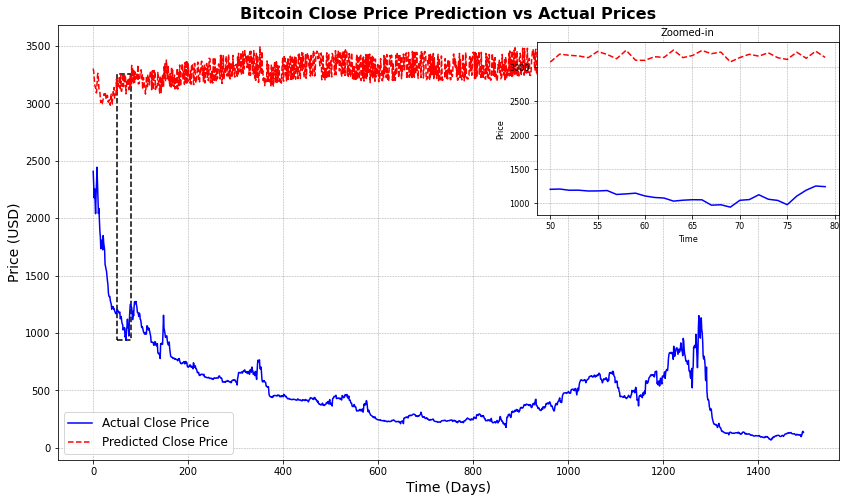

In [ ]:
new_data = pd.read_csv(r'bitcoin_price_Training - Training.csv')
new_data['Volume'] = new_data['Volume'].astype(str).str.replace(',', '').replace('-', '0').astype(float)
for col in ['Open', 'High', 'Low', 'Close']:
    new_data[col] = pd.to_numeric(new_data[col], errors='coerce')
new_data.dropna(inplace=True)
# Step 2: Select the same features and scale
new_data = new_data[features]  # Using the same 'features' list as before
scaled_new_data = scaler.transform(new_data)  # Use the same scaler from training

X_new, y_new = create_sequences(scaled_new_data, SEQ_LENGTH)
X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], len(features)))

predict_and_plot_with_zoom(model_lstm_1before, X_new, y_new, scaler, start=50, end=80)


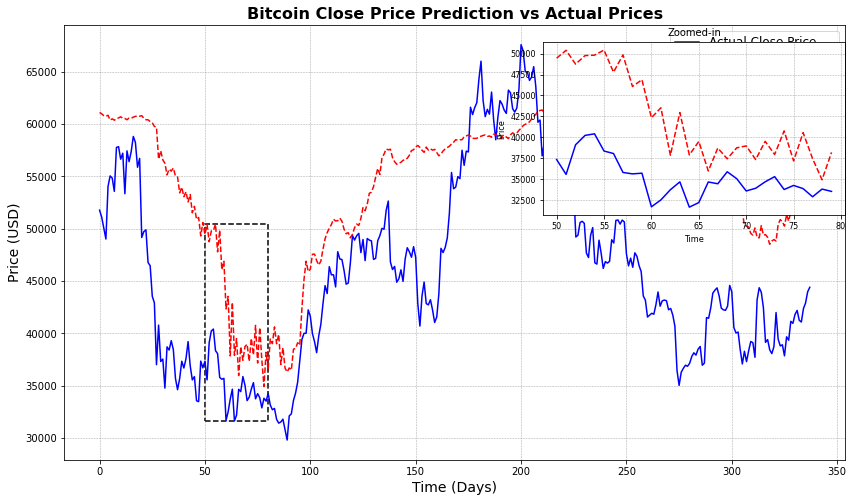

In [ ]:
predict_and_plot_with_zoom(model_lstm_1before, X_test, y_test, scaler, start=50, end=80)


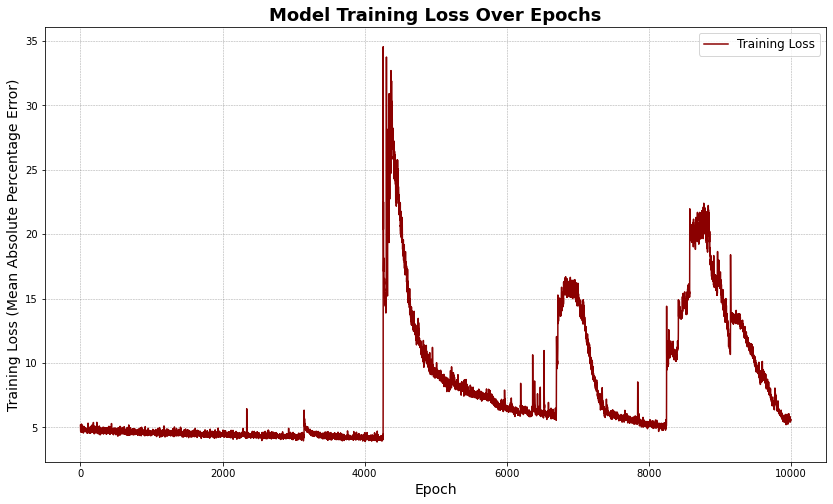

In [ ]:
plot_training_loss(historyX)